#  QUANTUM TELEPORTATION ALGORITHM

The objective of this algorithm is to *teleport* a state from one qubit to another. To do this we will make use of a third auxiliar qubit. This concept can be interpreted as Alice encoding a quantum state on a qubit she posseses, and she wants to send this state to Bob. To do so, a third party, Charlie entangles two qubits and hands one to Alice and another to Bob.

The algorithm starts by initializing the state Alice wants to send, by encoding it into her qubit. Next, she entangles it with the qubit Charlie gave her. Afterwards, she performs a measurement on each of the qubits she owns and sends the outcomes via a classical channel to Bob. Depending on these results, Bob performs a series of gates on his qubit. The resulting state is the one Alice encoded.

Refs.:

[1] Further details can be found in Qiskit tutorial notes: https://qiskit.org/textbook/ch-algorithms/teleportation.html

[2] Nielsen and Chuang - *Quantum computation and quantum information*

In [1]:
from qiskit import *

In [27]:
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

In [2]:
%matplotlib inline

In [12]:
qr = QuantumRegister(3)
cr = ClassicalRegister(3)

circuit = QuantumCircuit(qr,cr)

Here we define the frist qubit q0 as the qubit initialized by Alice, which contains the state to be ''teleported''. The second and third qubit, q1 and q2, are the qubits entangles by Charlie and handed to Alice and Bob, respectively.

### Initialization of the state

We initialize the state we want to teleport in the first qubit q0

In [14]:
# Initialize it in state |1>

circuit.x(qr[0])

We introduce barriers to distinguish the different stages in the circuit - *Only for aesthetics reasons*

In [15]:
circuit.barrier(qr)

### Algorithm - Building the circuit

First we entangle the second and third qubits, i.e. the operation Charlie performs on these two qubits before hanging them to Alice and Bob. Next, Alice performs a two-qubit operation with her two qubits and a single-qubit one the original qubit, in order for the two measurements later can provide the information Bob will need to retrieve the original state.

In [17]:
# Entanglement operation performed by Charlie
circuit.h(qr[1])
circuit.cx(qr[1],qr[2])

# Gates performed by Alice in order to send the approriate informatino to Bob
circuit.cx(qr[0],qr[1])
circuit.h(qr[0])

In [19]:
circuit.barrier(qr)

At this point, depending on the state of the first two qubits, Bob will have to perform a set of gates to retrieve the original state. Nevertheless, real quantum computers do not support further instructions after measurements. Thuse, we resort to the *deferred measurement principle* - see [2], section 4.4-, which tells us that all measurements can be deferred to the end of the circuit.

In order to implement this, we simply operate on Bob's qubit conditioned on Alice's qubits, and measure Bob's qubit at the end.

In [21]:
# Conditioned gates applied on Bob's qubit
circuit.cx(qr[1],qr[2])
circuit.cz(qr[0],qr[2])

In [22]:
circuit.barrier(qr)

Now we perform a measurement on Bob's qubit

In [25]:
circuit.measure(qr[2],cr[2])

Below we show the diagramatic representation of the circuit we built

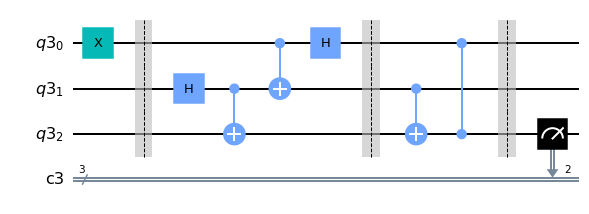

In [26]:
circuit.draw('mpl')

### Algorithm - Execution

#### Classical simulation

We first perform a simulation in our local computer using the Aer backend

In [28]:
simulator = Aer.get_backend('qasm_simulator') # Define the backend
result = execute(circuit, backend = simulator).result() # Execute the circuit in the backend

We then plot the results of our simulation on using in a probability histogram

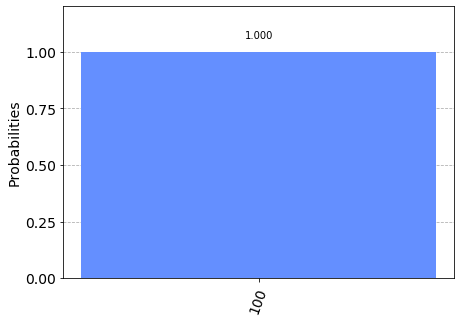

In [29]:
plot_histogram(result.get_counts(circuit))

As expected, we obtain the original state in Bob's qubit with probability 1.

*Note: the histogram state is to be read vertically from up to down in the same way we read te circuit*

#### Quantum simulation

To run this circuit in a real quantum computer, we need to first access the IBM experience, and then choose the quantum computer we want to use to execute the circuit.

In [30]:
# Load out IBM Experience account
IBMQ.load_account()

/opt/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [31]:
provider = IBMQ.get_provider('ibm-q') # Choose provider
qcomp = provider.get_backend('ibmq_athens') # Choose a specific quantum computer to run the circuit
job = execute(circuit,backend = qcomp) # Execute the circuit

In [32]:
# Using the monitor we can keep track of the status of the execution, i.e. place in the queue 
# and whether it is pending or it has been executed
job_monitor(job)

Job Status: job has successfully run


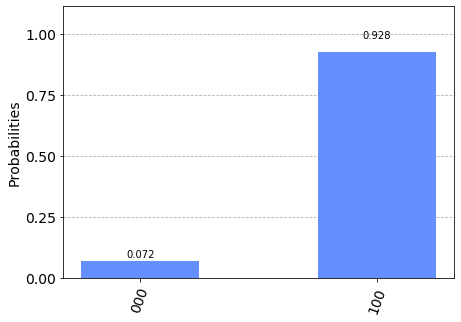

In [33]:
# We retrieve the results from the execution and plot it in a histogram
result_realq = job.result() 
plot_histogram(result_realq.get_counts(circuit))

As we can see, the state has been transferred to Bob, and since the simulation has been run in a real quantum computer, there is small amount of error, resulting in runs ending up in the state 000.